## Needed Libraries

In [246]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from datetime import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import mean_absolute_error
pd.options.mode.chained_assignment = None  # default='warn'

### Importing CSV Files and preprocessing ETH Data

In [247]:
# Ethereum Data
df_eth = pd.read_csv("lunarcrush_eth.csv") 
df_eth_features = df_eth[["time","close","reddit_posts","reddit_comments","tweets","tweet_sentiment1","tweet_sentiment2","tweet_sentiment3","tweet_sentiment4","tweet_sentiment5","social_score","social_contributors","news"]]
df_eth_features['date'] = [dt.datetime.fromtimestamp(i).strftime('%d-%m-%Y') for i in df_eth_features['time']]
df_eth_features.index = df_eth_features['date']

df_eth_twitter = df_eth_features[["date","close","tweets","tweet_sentiment1","tweet_sentiment2","tweet_sentiment3","tweet_sentiment4","tweet_sentiment5"]]
df_eth_other = df_eth_features[["date","close","reddit_posts","reddit_comments","social_score","social_contributors","news"]]

df_eth_other['reddit_posts'] = df_eth_other['reddit_posts'].astype("float")
df_eth_other['reddit_comments'] = df_eth_other['reddit_comments'].astype("float")
df_eth_other['social_contributors'] = df_eth_other['social_contributors'].astype("float")

#df_eth_other
#df_eth_twitter

In [248]:
# Check null values
df_eth_other.isnull().sum()
# Some null values need to be deleted

date                    0
close                   0
reddit_posts            0
reddit_comments         0
social_score           27
social_contributors     0
news                   22
dtype: int64

In [249]:
# Check null values
df_eth_twitter.isnull().sum()
# Some null values need to be deleted

date                 0
close                0
tweets              27
tweet_sentiment1    27
tweet_sentiment2    27
tweet_sentiment3    27
tweet_sentiment4    27
tweet_sentiment5    27
dtype: int64

In [250]:
df_eth_other.dropna(subset=['social_score', 'news'], inplace=True)
df_eth_twitter.dropna(subset=['tweets','tweet_sentiment1', 'tweet_sentiment2', 'tweet_sentiment3', 'tweet_sentiment4', 'tweet_sentiment5'], inplace=True)

In [251]:
df_eth_twitter

,date,close,tweets,tweet_sentiment1,tweet_sentiment2,tweet_sentiment3,tweet_sentiment4,tweet_sentiment5
date,,,,,,,,
24-05-2019,24-05-2019,250.225438,14535.0,186.0,234.0,4804.0,5600.0,573.0
25-05-2019,25-05-2019,252.202778,11833.0,122.0,237.0,4039.0,4333.0,399.0
26-05-2019,26-05-2019,268.877157,11734.0,140.0,256.0,3169.0,4663.0,392.0
27-05-2019,27-05-2019,271.890620,14138.0,159.0,263.0,3758.0,5440.0,435.0
28-05-2019,28-05-2019,271.740219,13225.0,203.0,203.0,3311.0,5828.0,436.0
...,...,...,...,...,...,...,...,...
08-05-2021,08-05-2021,3903.622996,56664.0,1176.0,4945.0,6419.0,41911.0,2213.0
09-05-2021,09-05-2021,3928.562387,56367.0,1078.0,7459.0,5170.0,40633.0,2027.0
10-05-2021,10-05-2021,3973.754840,76761.0,1728.0,6095.0,7837.0,58378.0,2723.0


In [252]:
df_eth_other

,date,close,reddit_posts,reddit_comments,social_score,social_contributors,news
date,,,,,,,
24-05-2019,24-05-2019,250.225438,75.0,1502.0,8662.0,1817.0,80.0
25-05-2019,25-05-2019,252.202778,41.0,1069.0,5412.0,1882.0,32.0
26-05-2019,26-05-2019,268.877157,59.0,1307.0,9417545.0,1390.0,44.0
27-05-2019,27-05-2019,271.890620,84.0,1672.0,18229417.0,1465.0,61.0
28-05-2019,28-05-2019,271.740219,53.0,1717.0,46368962.0,1723.0,91.0
...,...,...,...,...,...,...,...
08-05-2021,08-05-2021,3903.622996,1226.0,3472.0,307025580.0,69847.0,120.0
09-05-2021,09-05-2021,3928.562387,1428.0,3315.0,236920848.0,62015.0,102.0
10-05-2021,10-05-2021,3973.754840,1661.0,4561.0,498811725.0,60187.0,256.0


## Correlation Graphs

<AxesSubplot:>

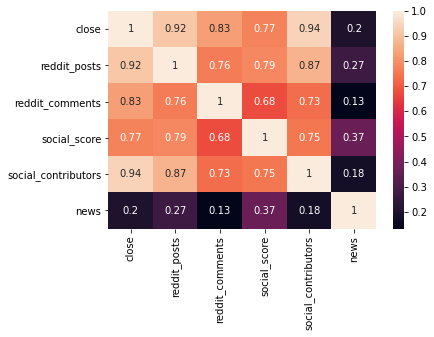

In [253]:
sns.heatmap(df_eth_other.corr(),annot = True)

<AxesSubplot:>

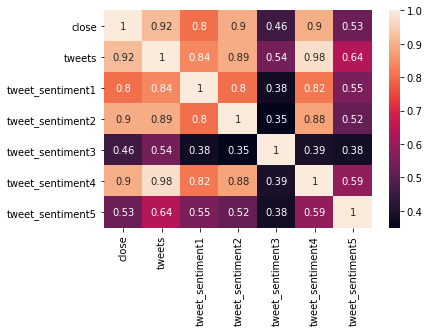

In [254]:
sns.heatmap(df_eth_twitter.corr(),annot = True)

In [255]:
# Best correlation features to the closing price of ethereum are
# tweets, tweet_sentiment1, tweet_sentiment2, tweet_sentiment4, 
# reddit_posts, reddit_comments, social_score, social_contributors

In [256]:
# Getting all of these correlations in a single dataframe 
main_df = pd.DataFrame()
main_df = df_eth_twitter[["date","close","tweets","tweet_sentiment1","tweet_sentiment2","tweet_sentiment4"]]
main_df.drop('date',axis='columns', inplace=True)

main_df['reddit_posts'] = df_eth_other['reddit_posts']
main_df['reddit_comments'] = df_eth_other['reddit_comments']
main_df['social_score'] = df_eth_other['social_score']
main_df['social_contributors'] = df_eth_other['social_contributors']

main_df_scaled_tmp = main_df.copy()

main_df

,close,tweets,tweet_sentiment1,tweet_sentiment2,tweet_sentiment4,reddit_posts,reddit_comments,social_score,social_contributors
date,,,,,,,,,
24-05-2019,250.225438,14535.0,186.0,234.0,5600.0,75.0,1502.0,8662.0,1817.0
25-05-2019,252.202778,11833.0,122.0,237.0,4333.0,41.0,1069.0,5412.0,1882.0
26-05-2019,268.877157,11734.0,140.0,256.0,4663.0,59.0,1307.0,9417545.0,1390.0
27-05-2019,271.890620,14138.0,159.0,263.0,5440.0,84.0,1672.0,18229417.0,1465.0
28-05-2019,271.740219,13225.0,203.0,203.0,5828.0,53.0,1717.0,46368962.0,1723.0
...,...,...,...,...,...,...,...,...,...
08-05-2021,3903.622996,56664.0,1176.0,4945.0,41911.0,1226.0,3472.0,307025580.0,69847.0
09-05-2021,3928.562387,56367.0,1078.0,7459.0,40633.0,1428.0,3315.0,236920848.0,62015.0
10-05-2021,3973.754840,76761.0,1728.0,6095.0,58378.0,1661.0,4561.0,498811725.0,60187.0


## Graphs to visualize the Ethereum data

In [257]:
# Scaling to fit into a graph
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
main_df_scaled_tmp[["close","tweets","tweet_sentiment1","tweet_sentiment2","tweet_sentiment4","reddit_posts","reddit_comments","social_score","social_contributors"]] = min_max_scaler.fit_transform(main_df_scaled_tmp[["close","tweets","tweet_sentiment1","tweet_sentiment2","tweet_sentiment4","reddit_posts","reddit_comments","social_score","social_contributors"]])
main_df_scaled_tmp

,close,tweets,tweet_sentiment1,tweet_sentiment2,tweet_sentiment4,reddit_posts,reddit_comments,social_score,social_contributors
date,,,,,,,,,
24-05-2019,0.034270,0.117105,0.065678,0.022687,0.043191,0.035597,0.320222,0.000004,0.014215
25-05-2019,0.034758,0.085786,0.043079,0.023067,0.024753,0.016977,0.224000,0.000000,0.014978
26-05-2019,0.038871,0.084638,0.049435,0.025475,0.029556,0.026835,0.276889,0.012903,0.009203
27-05-2019,0.039614,0.112503,0.056144,0.026362,0.040863,0.040526,0.358000,0.024983,0.010083
28-05-2019,0.039577,0.101921,0.071681,0.018758,0.046509,0.023549,0.368000,0.063559,0.013112
...,...,...,...,...,...,...,...,...,...
08-05-2021,0.935457,0.605427,0.415254,0.619772,0.571597,0.665936,0.758000,0.420890,0.812764
09-05-2021,0.941609,0.601984,0.380650,0.938403,0.552999,0.776561,0.723111,0.324784,0.720831
10-05-2021,0.952757,0.838374,0.610169,0.765526,0.811228,0.904162,1.000000,0.683807,0.699373


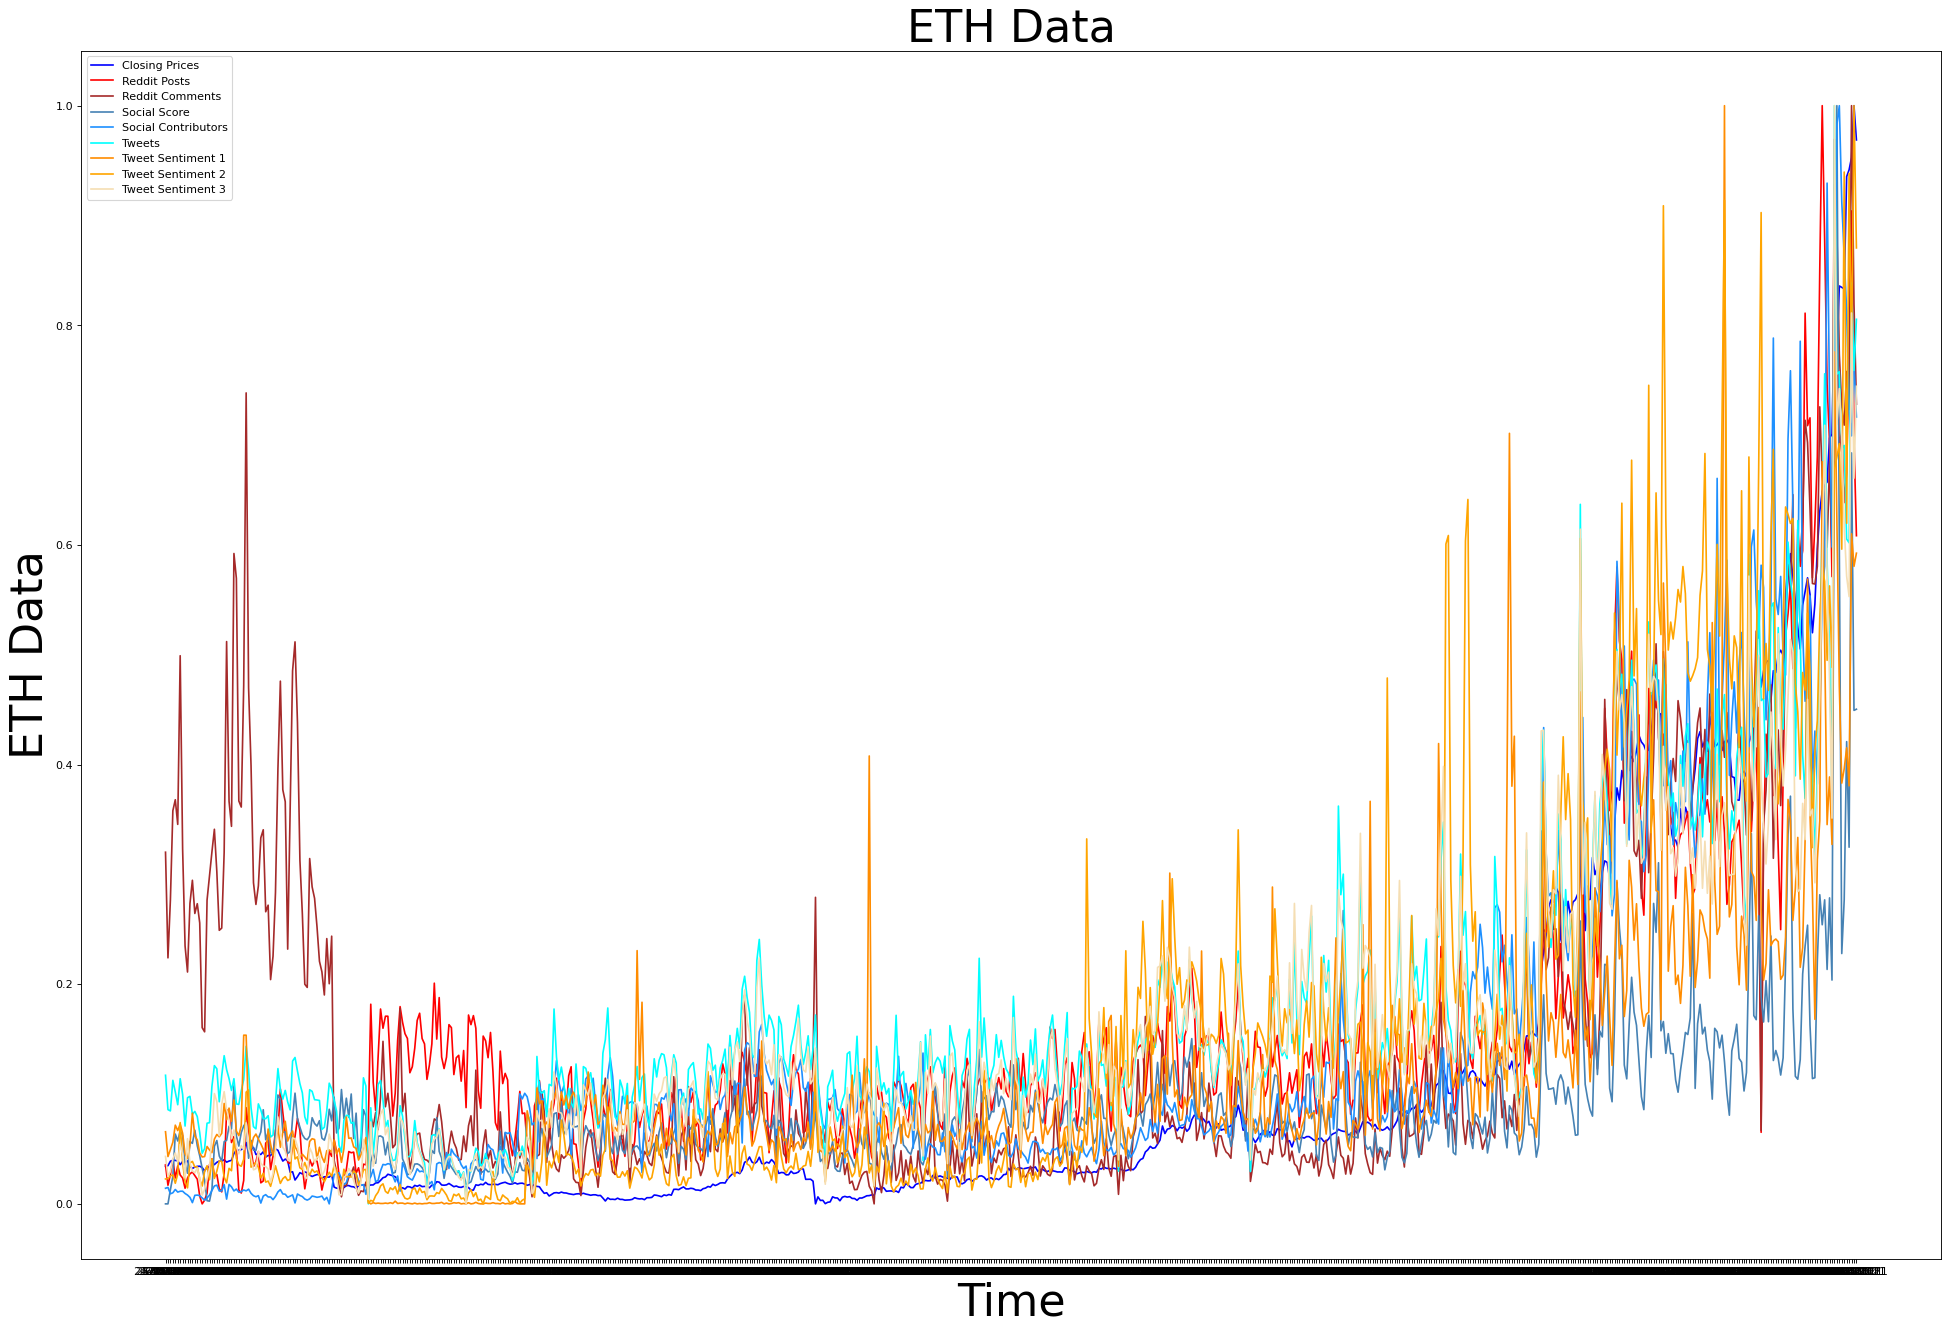

In [258]:
plt.figure(figsize=(30, 20), dpi=80, facecolor = 'w', edgecolor = 'k')

plt.plot(main_df_scaled_tmp.index,main_df_scaled_tmp['close'], color='blue', label='Closing Prices')
plt.plot(main_df_scaled_tmp.index,main_df_scaled_tmp['reddit_posts'], color='red', label='Reddit Posts')
plt.plot(main_df_scaled_tmp.index,main_df_scaled_tmp['reddit_comments'], color='brown', label='Reddit Comments')
plt.plot(main_df_scaled_tmp.index,main_df_scaled_tmp['social_score'], color='steelblue', label='Social Score')
plt.plot(main_df_scaled_tmp.index,main_df_scaled_tmp['social_contributors'], color='dodgerblue', label='Social Contributors')

plt.plot(main_df_scaled_tmp.index,main_df_scaled_tmp['tweets'], color='aqua', label='Tweets')
plt.plot(main_df_scaled_tmp.index,main_df_scaled_tmp['tweet_sentiment1'], color='darkorange', label='Tweet Sentiment 1')
plt.plot(main_df_scaled_tmp.index,main_df_scaled_tmp['tweet_sentiment2'], color='orange', label='Tweet Sentiment 2')
plt.plot(main_df_scaled_tmp.index,main_df_scaled_tmp['tweet_sentiment4'], color='wheat', label='Tweet Sentiment 3')


plt.title('ETH Data', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('ETH Data', fontsize = 40)
plt.legend()
plt.show()

### Splitting the data for train and test


In [259]:
main_df

,close,tweets,tweet_sentiment1,tweet_sentiment2,tweet_sentiment4,reddit_posts,reddit_comments,social_score,social_contributors
date,,,,,,,,,
24-05-2019,250.225438,14535.0,186.0,234.0,5600.0,75.0,1502.0,8662.0,1817.0
25-05-2019,252.202778,11833.0,122.0,237.0,4333.0,41.0,1069.0,5412.0,1882.0
26-05-2019,268.877157,11734.0,140.0,256.0,4663.0,59.0,1307.0,9417545.0,1390.0
27-05-2019,271.890620,14138.0,159.0,263.0,5440.0,84.0,1672.0,18229417.0,1465.0
28-05-2019,271.740219,13225.0,203.0,203.0,5828.0,53.0,1717.0,46368962.0,1723.0
...,...,...,...,...,...,...,...,...,...
08-05-2021,3903.622996,56664.0,1176.0,4945.0,41911.0,1226.0,3472.0,307025580.0,69847.0
09-05-2021,3928.562387,56367.0,1078.0,7459.0,40633.0,1428.0,3315.0,236920848.0,62015.0
10-05-2021,3973.754840,76761.0,1728.0,6095.0,58378.0,1661.0,4561.0,498811725.0,60187.0


In [260]:
# Converting dates as a datetime object
main_df['date_features'] = main_df.index
main_df['date_features'] = main_df['date_features'].astype("str")

In [261]:
datelist_train = list(main_df['date_features'])
datelist_train = [dt.datetime.strptime(date, '%d-%m-%Y').date() for date in datelist_train]
main_df.index = datelist_train

In [262]:
# Splitting the data to train and test based on the prediction day we want

date_string = "21 February, 2021"
#possible parameter %H:%M:%S

dt_onject_split = dt.datetime.strptime(date_string, "%d %B, %Y").date()
data_train = main_df.loc[main_df.index <= dt_onject_split].copy()
data_test = main_df.loc[main_df.index > dt_onject_split].copy()

print("Data train shape",data_train.shape)
print("Data test shape",data_test.shape)

Data train shape (613, 10)
Data test shape (80, 10)


In [263]:
def create_features_with_twitter(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Date'] = df.index
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Day of Month'] = df['Date'].dt.day
    X = df[['Month','Year','Day of Month','tweets', 'tweet_sentiment1', 'tweet_sentiment2', 'tweet_sentiment4']]
    if label:
        y = df[label]
        return X, y
    return X

# 'tweets', 'tweet_sentiment1', 'tweet_sentiment2', 'tweet_sentiment4', 
# 'reddit_posts', 'reddit_comments', 'social_score', 'social_contributors'

def create_features_without_news_reddit(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Hafta'] = df.index
    df['Hafta'] = pd.to_datetime(df['Hafta'], errors='coerce')
    df['Month'] = df['Hafta'].dt.month
    df['Year'] = df['Hafta'].dt.year
    df['Day of Month'] = df['Hafta'].dt.day
    X = df[['Month','Year','Day of Month','reddit_posts', 'reddit_comments', 'social_score', 'social_contributors']]
    if label:
        y = df[label]
        return X, y
    return X

In [264]:
# Twitter Data
X_train_twitter, y_train_twitter = create_features_with_twitter(data_train, label='close')
X_test_twitter, y_test_twitter = create_features_with_twitter(data_test, label='close')

# News and Reddit data
X_train_news_reddit, y_train_news_reddit = create_features_without_news_reddit(data_train, label='close')
X_test_news_reddit, y_test_news_reddit = create_features_without_news_reddit(data_test, label='close')

X_train_twitter

,Month,Year,Day of Month,tweets,tweet_sentiment1,tweet_sentiment2,tweet_sentiment4
2019-05-24,5,2019,24,14535.0,186.0,234.0,5600.0
2019-05-25,5,2019,25,11833.0,122.0,237.0,4333.0
2019-05-26,5,2019,26,11734.0,140.0,256.0,4663.0
2019-05-27,5,2019,27,14138.0,159.0,263.0,5440.0
2019-05-28,5,2019,28,13225.0,203.0,203.0,5828.0
...,...,...,...,...,...,...,...
2021-02-17,2,2021,17,44473.0,970.0,2721.0,34704.0
2021-02-18,2,2021,18,45828.0,1042.0,3803.0,35635.0
2021-02-19,2,2021,19,46770.0,808.0,5163.0,35363.0
2021-02-20,2,2021,20,43569.0,805.0,4392.0,33303.0


## Create an LSTM model. 

In [265]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

In [266]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler_x = MinMaxScaler()
min_max_scaler_y = MinMaxScaler()

In [267]:
x_training_set = X_train_twitter.values
x_training_set = x_training_set[0:len(x_training_set)]

x_training_set = min_max_scaler_x.fit_transform(x_training_set)
x_training_set = x_training_set.reshape((x_training_set.shape[0], 1, x_training_set.shape[1]))

y_train = pd.DataFrame(y_train_twitter)
list(y_train['close'])
y_train_values = [float(i) for i in y_train['close']]
y_train_values = np.array(y_train_values)
y_train_values = np.array(y_train_values)

y_train_values = np.reshape(y_train_values, (len(y_train_values), 1))
y_training_set = min_max_scaler_y.fit_transform(y_train_values)

In [268]:
# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, input_shape=(x_training_set.shape[1], x_training_set.shape[2])))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Using the training set to train the model
regressor.fit(x_training_set, y_training_set, batch_size = 5, epochs = 100)

Epoch 1/100
123/123 [==============================] - 2s 1ms/step - loss: 0.0349
Epoch 2/100
123/123 [==============================] - 0s 918us/step - loss: 0.0109
Epoch 3/100
123/123 [==============================] - 0s 926us/step - loss: 0.0088
Epoch 4/100
123/123 [==============================] - 0s 1ms/step - loss: 0.0070
Epoch 5/100
123/123 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 6/100
123/123 [==============================] - 0s 959us/step - loss: 0.0057
Epoch 7/100
123/123 [==============================] - 0s 926us/step - loss: 0.0065
Epoch 8/100
123/123 [==============================] - 0s 943us/step - loss: 0.0059
Epoch 9/100
123/123 [==============================] - 0s 907us/step - loss: 0.0070
Epoch 10/100
123/123 [==============================] - 0s 907us/step - loss: 0.0055
Epoch 11/100
123/123 [==============================] - 0s 929us/step - loss: 0.0053
Epoch 12/100
123/123 [==============================] - 0s 1ms/step - loss: 0.00

123/123 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 99/100
123/123 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 100/100
123/123 [==============================] - 0s 1ms/step - loss: 0.0016


In [269]:
test_set = X_test_twitter.values

# Reshaping and scaling the inputs
inputs = np.reshape(test_set, (len(test_set), 7))
inputs = min_max_scaler_x.transform(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 7))
predicted_price = regressor.predict(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 7))
predicted_price = min_max_scaler_y.inverse_transform(predicted_price)

In [270]:
predicted_price

array([[2002.8154],
       [1790.3868],
       [1714.7466],
       [1702.0178],
       [1697.2767],
       [1684.6375],
       [1722.6592],
       [1689.7264],
       [1683.6182],
       [1699.4941],
       [1668.809 ],
       [1586.2548],
       [1605.8131],
       [1595.9755],
       [1636.5757],
       [1716.6537],
       [1685.7928],
       [1817.673 ],
       [1671.1316],
       [1674.2367],
       [1574.7423],
       [1700.5594],
       [1830.3196],
       [1689.0615],
       [1873.3124],
       [1882.5656],
       [1757.5548],
       [1660.6556],
       [1654.5598],
       [1693.3645],
       [1743.5396],
       [1686.0103],
       [1881.3033],
       [1533.0697],
       [1469.3771],
       [1952.1708],
       [1777.2139],
       [1677.9532],
       [1684.7715],
       [1821.9856],
       [1962.2528],
       [1656.1185],
       [1657.7754],
       [1643.517 ],
       [1840.4696],
       [1888.45  ],
       [1623.8647],
       [1684.9755],
       [1669.5618],
       [1751.5957],


In [271]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_twitter,predicted_price,squared=False)

769.6435317724932

In [272]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_twitter,predicted_price)

523.3670630801289

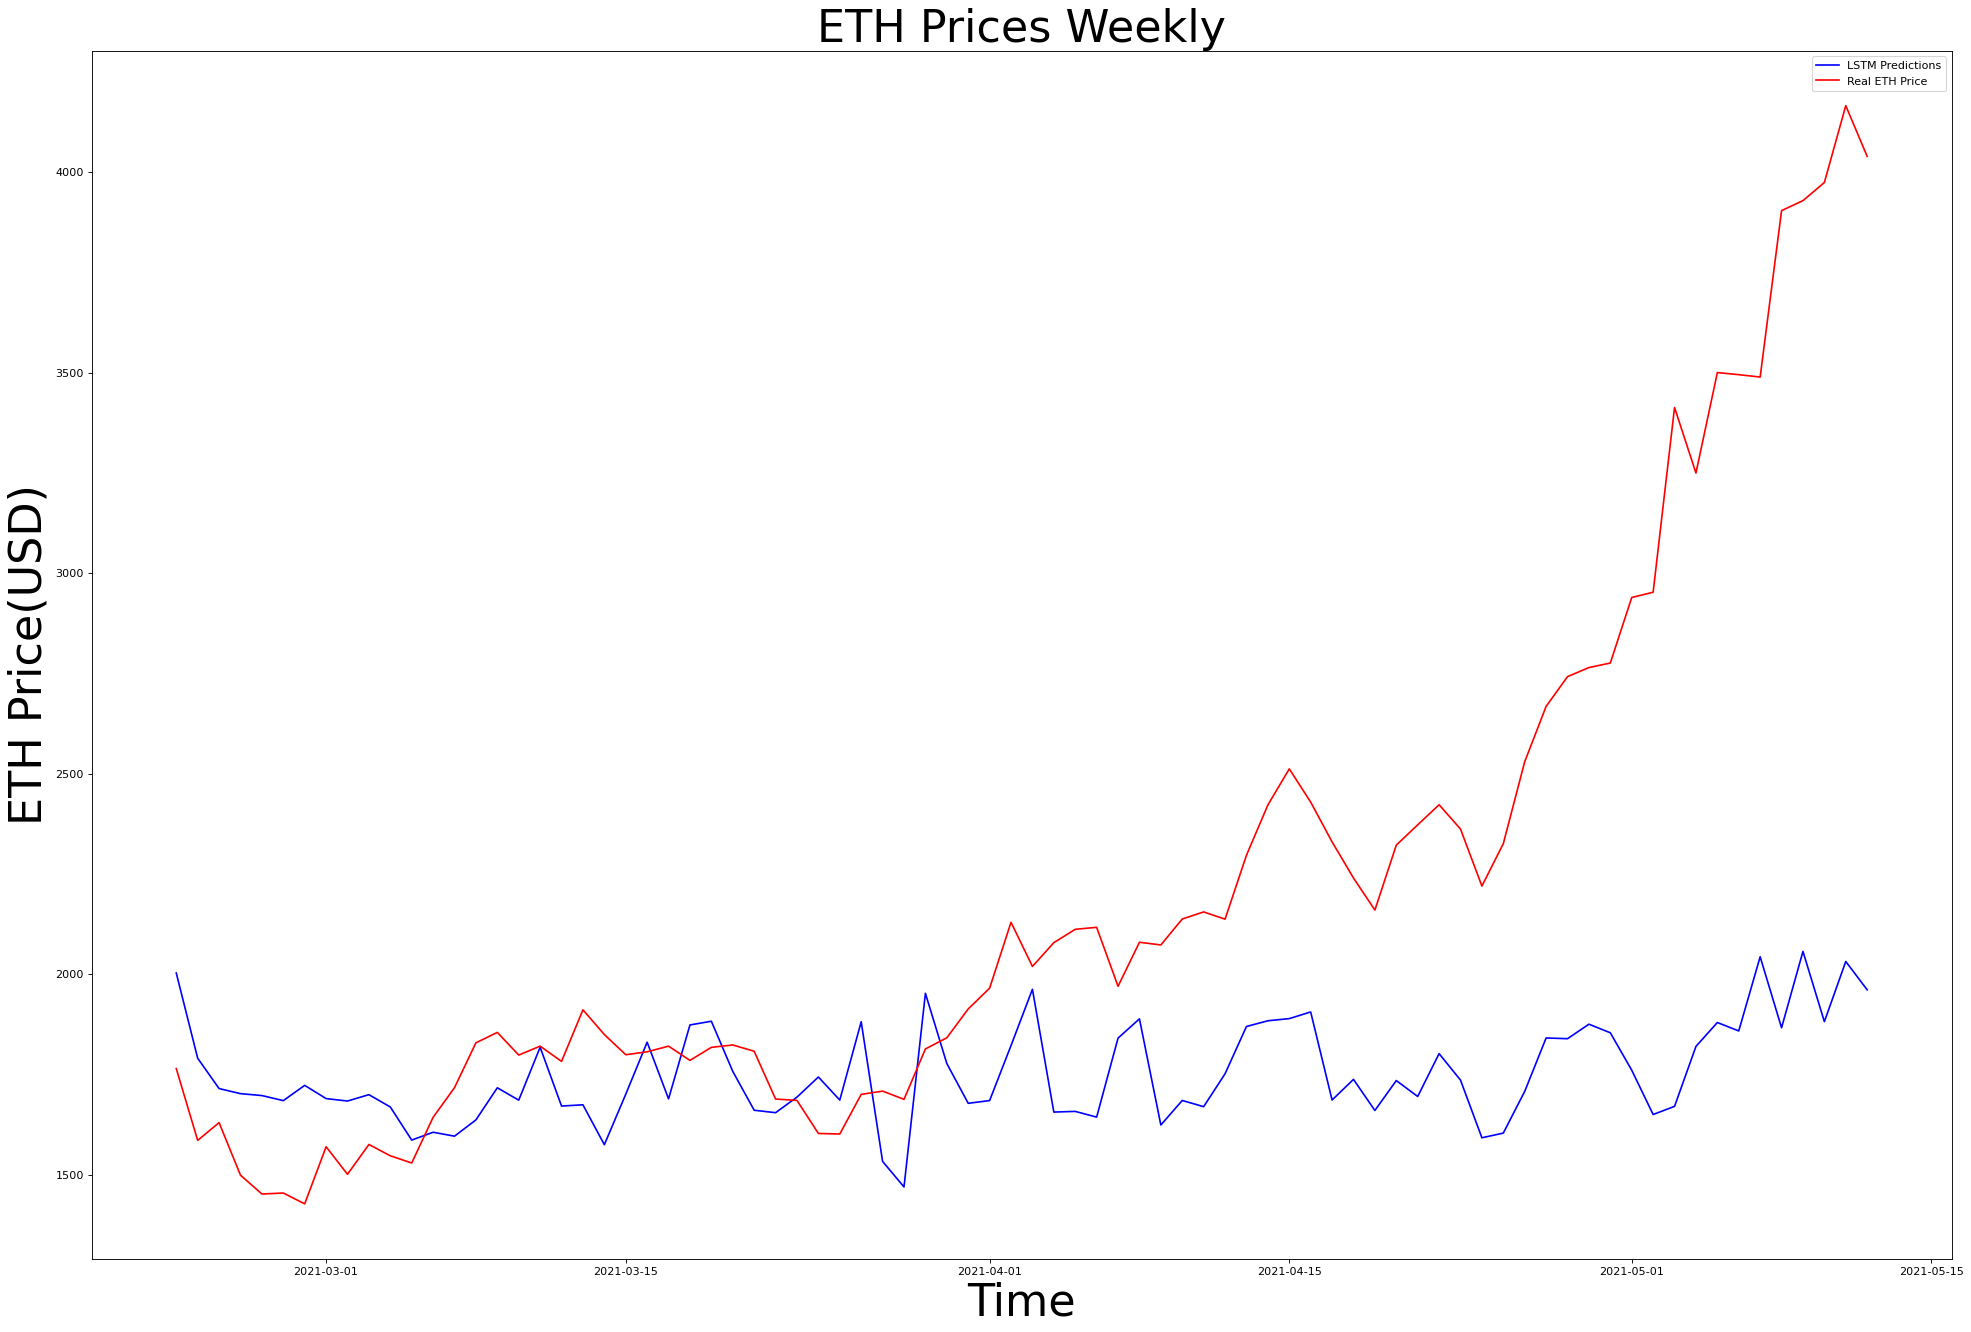

In [273]:
y_test_values = [float(i) for i in y_test_twitter]
plt.figure(figsize=(30, 20), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(X_test_twitter.index,predicted_price, color='blue', label='LSTM Predictions')
plt.plot(X_test_twitter.index,y_test_values, color='red', label='Real ETH Price')
plt.title('ETH Prices Weekly', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('ETH Price(USD)', fontsize = 40)
plt.legend()
plt.show()

# Now we will implement with the other dataset news and reddit data

In [274]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler_x = MinMaxScaler()
min_max_scaler_y = MinMaxScaler()

In [275]:
x_training_set = X_train_news_reddit.values
x_training_set = x_training_set[0:len(x_training_set)]

x_training_set = min_max_scaler_x.fit_transform(x_training_set)
x_training_set = x_training_set.reshape((x_training_set.shape[0], 1, x_training_set.shape[1]))

y_train = pd.DataFrame(y_train_news_reddit)
list(y_train['close'])
y_train_values = [float(i) for i in y_train['close']]
y_train_values = np.array(y_train_values)
y_train_values = np.array(y_train_values)

y_train_values = np.reshape(y_train_values, (len(y_train_values), 1))
y_training_set = min_max_scaler_y.fit_transform(y_train_values)

In [276]:
# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, input_shape=(x_training_set.shape[1], x_training_set.shape[2])))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Using the training set to train the model
regressor.fit(x_training_set, y_training_set, batch_size = 5, epochs = 100)

Epoch 1/100
123/123 [==============================] - 2s 1ms/step - loss: 0.0320
Epoch 2/100
123/123 [==============================] - 0s 934us/step - loss: 0.0083
Epoch 3/100
123/123 [==============================] - 0s 934us/step - loss: 0.0062
Epoch 4/100
123/123 [==============================] - 0s 936us/step - loss: 0.0044
Epoch 5/100
123/123 [==============================] - 0s 959us/step - loss: 0.0039
Epoch 6/100
123/123 [==============================] - 0s 977us/step - loss: 0.0039
Epoch 7/100
123/123 [==============================] - 0s 955us/step - loss: 0.0034
Epoch 8/100
123/123 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 9/100
123/123 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 10/100
123/123 [==============================] - 0s 934us/step - loss: 0.0030
Epoch 11/100
123/123 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 12/100
123/123 [==============================] - 0s 977us/step - loss: 0.00

In [277]:
test_set = X_test_news_reddit.values
# Reshaping and scaling the inputs
inputs = np.reshape(test_set, (len(test_set), 7))
inputs = min_max_scaler_x.transform(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 7))
predicted_price = regressor.predict(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 7))
predicted_price = min_max_scaler_y.inverse_transform(predicted_price)

In [278]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_news_reddit,predicted_price,squared=False)

737.9458575835581

In [279]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_news_reddit,predicted_price)

450.6841901928945

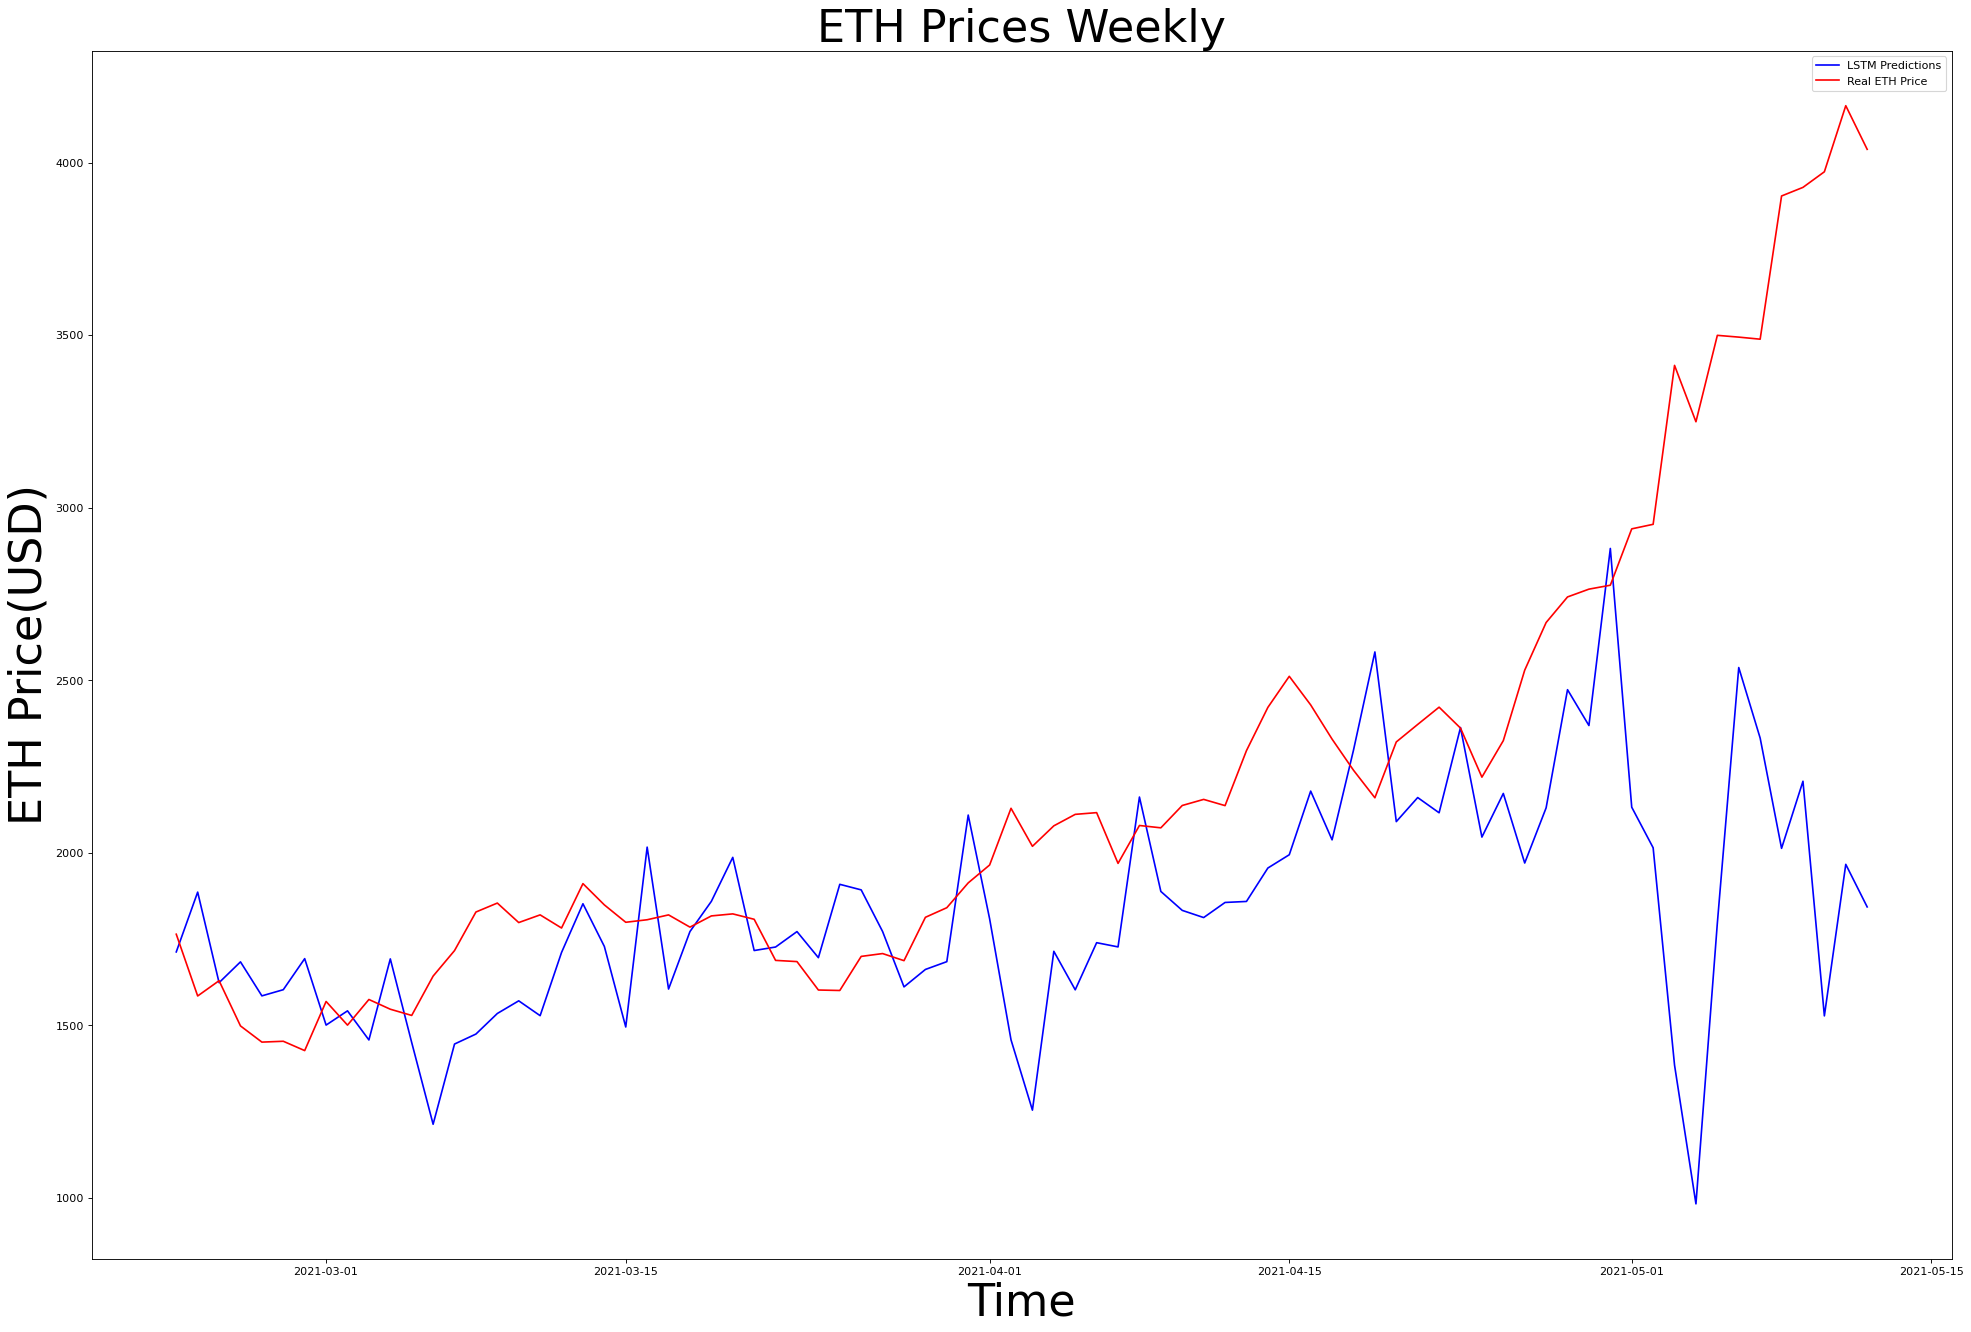

In [280]:
y_test_values = [float(i) for i in y_test_news_reddit]
plt.figure(figsize=(30, 20), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(X_test_news_reddit.index,predicted_price, color='blue', label='LSTM Predictions')
plt.plot(X_test_news_reddit.index,y_test_values, color='red', label='Real ETH Price')
plt.title('ETH Prices Weekly', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('ETH Price(USD)', fontsize = 40)
plt.legend()
plt.show()